In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utilities import *
from tqdm import tqdm

In [52]:
x_train, y_train, x_test, y_test = load_data()

In [53]:
print(f"Dimension of x_train : {x_train.shape}")
print(f"Dimension of y_train : {y_train.shape}")
print(np.unique(y_train, return_counts=True))

Dimension of x_train : (1000, 64, 64)
Dimension of y_train : (1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


In [54]:
print(f"Dimension of  x_test: {x_test.shape}")
print(f"Dimension of y_test : {y_test.shape}")
print(np.unique(y_test, return_counts=True))

Dimension of  x_test: (200, 64, 64)
Dimension of y_test : (200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


C:\Users\remi_\Anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


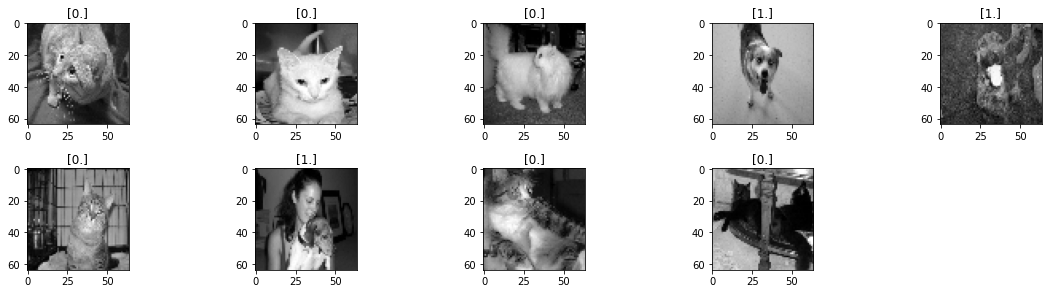

In [55]:
plt.figure(figsize=(16,8))
for i in range(1,10):
    plt.subplot(4, 5, i)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [56]:
def normalize(A, min=0, max=255):
    return (A - min) / (max - min)

In [57]:
x_train_norm = normalize(x_train, min=x_train.min(), max=x_train.max())
x_test_norm = normalize(x_test, min=x_train.min(), max=x_train.max())

print(f"Dimension of  x_train_norm: {x_train_norm.shape}")
print(f"Dimension of  x_test_norm: {x_test_norm.shape}")

Dimension of  x_train_norm: (1000, 64, 64)
Dimension of  x_test_norm: (200, 64, 64)


In [58]:
def flat_image(A):
    m = A.shape[0]
    image_size = A.shape[1] * A.shape[2]
    B = A.flatten().reshape(m, image_size)
    return B

In [59]:
x_train_flat = flat_image(x_train_norm)
x_test_flat = flat_image(x_test_norm)

print(f"Dimension of  x_train_flat: {x_train_flat.shape}")
print(f"Dimension of  x_test_flat: {x_test_flat.shape}")

# On transpose pour l'utilisation du réseau de neurones
x_train_flat = x_train_flat.T
y_train = y_train.T

x_test_flat = x_test_flat.T
y_test = y_test.T

print("---")
print("On transpose pour l'utilisation du réseau de neurones")
print(f"Dimension of  x_train_flat: {x_train_flat.shape}")
print(f"Dimension of  y_train: {y_train.shape}")
print(f"Dimension of  x_test_flat: {x_test_flat.shape}")
print(f"Dimension of  y_test: {y_test.shape}")

Dimension of  x_train_flat: (1000, 4096)
Dimension of  x_test_flat: (200, 4096)
---
On transpose pour l'utilisation du réseau de neurones
Dimension of  x_train_flat: (4096, 1000)
Dimension of  y_train: (1, 1000)
Dimension of  x_test_flat: (4096, 200)
Dimension of  y_test: (1, 200)


In [60]:
def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)

    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2)

    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
    }
    return params

In [61]:
def sigmoid(A):
    return 1/(1 + np.exp(-A))

In [62]:
def forward_propagation(X, params):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)

    activations = {
        "A1": A1,
        "A2": A2,
    }
    return activations

In [63]:
def log_loss(A, y, epsilon=1e-15):
    m = len(y)
    return -(1/m)*np.sum(y*np.log(A + epsilon) + (1-y)*np.log(1 - A + epsilon))

In [64]:
def back_propagation(X, y, activations, params):
    A2 = activations["A2"]
    A1 = activations["A1"]
    W2 = params["W2"]
    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2,
    }

    return gradients

In [65]:
def update(params, gradients, learning_rate):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    dW1 = gradients["dW1"]
    db1 = gradients["db1"]
    dW2 = gradients["dW2"]
    db2 = gradients["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
    }
    return params

In [66]:
def predict(X, params):
    activations = forward_propagation(X, params)
    A2 = activations["A2"]
    return A2 >= 0.5

In [67]:
def calcul_accuracy(X, y, params):
    y_pred = predict(X, params)
    return accuracy_score(y.flatten(), y_pred.flatten())

In [72]:
def neural_network(X_train, y_train, X_test, y_test, nbr_neurones, learning_rate=0.1, n_iter=1000):
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': [],
    }
    n0 = X_train.shape[0]
    n1 = nbr_neurones
    n2 = y_train.shape[0]
    params = initialisation(n0, n1, n2)
    
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X_train, params)

        if i % 10 == 0:
            # train
            A_train = activations["A2"]
            history['train_loss'].append(log_loss(A_train, y_train))
            history['train_accuracy'].append(calcul_accuracy(X_train, y_train, params))
            # test
            activations_test = forward_propagation(X_test, params)
            A_test = activations_test["A2"]
            history['test_loss'].append(log_loss(A_test, y_test))
            history['test_accuracy'].append(calcul_accuracy(X_test, y_test, params))

        gradients = back_propagation(X_train, y_train, activations, params)
        params = update(params, gradients, learning_rate)


    print(f"Accuracy score (train set): {calcul_accuracy(X_train, y_train, params)}")
    print(f"Accuracy score (test set): {calcul_accuracy(X_test, y_test, params)}")
    return (params, history)

In [69]:
def display_loss_acc(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(history['train_loss'], label="train")
    plt.plot(history['test_loss'], label="test")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(history['train_accuracy'], label="train")
    plt.plot(history['test_accuracy'], label="test")
    plt.legend()
    plt.show()

In [95]:
(params, history) = neural_network(x_train_flat, y_train, x_test_flat, y_test, nbr_neurones=32, learning_rate=0.1, n_iter=3000)

100%|██████████| 3000/3000 [00:41<00:00, 71.89it/s]

Accuracy score (train set): 0.739
Accuracy score (test set): 0.55


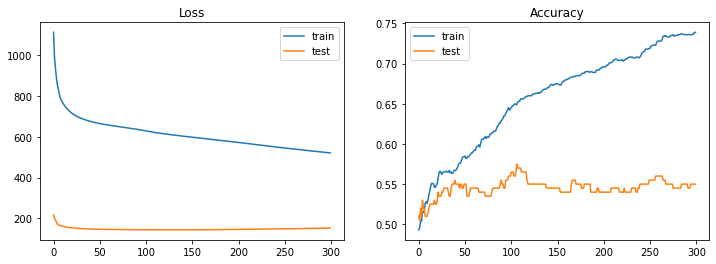

In [96]:
display_loss_acc(history)